<a href="https://colab.research.google.com/github/SBShimm/Aiffel/blob/master/GoingDeeper/GoingDeeper_NLP4_SB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vocabulary Size를 변경해서 뉴스 카테고리 분류

앞서 사용했던 로이터 뉴스 데이터의 Vocabulary Size에 따라 학습 결과가 어떻게 바뀌는지 알아보자.

## 1. 데이터 불러오기  
일단 필요한 패키지를 불러온다.

In [1]:
import pandas as pd
import numpy as np
import urllib.request
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


노드에서 사용했던 대로 일단 만개의 단어를 사용해 불러온다.  
num_words에 따라 빈도수가 많은 단어를 사용하는 데이터만 가져온다.

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [5]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


상위 만개 단어를 사용하는 데이터는 훈련 8982, 테스트 2246개의 데이터로 구성되고 46개의 클래스로 분류된다.

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


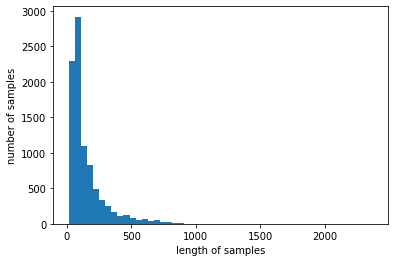

In [6]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

뉴스 길이 분포를 살펴보면 대부분은 0~200정도의 길이이고 500부터는 낮은 분포를 보입니다. 최대 길이 2376은 유독 길어보입니다.

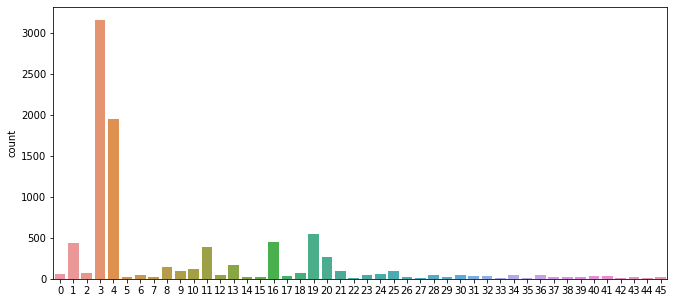

In [7]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

클래스 분포를 살펴보면 3, 4번 클래스가 대부분을 차지하고 그 뒤로 1, 11, 16, 19번 등의 데이터에 높은 분포를 가집니다.  
아래는 클래스 빈도수를 수치로 나타냅니다.

In [8]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


이제 특별한 벡터화를 사용하기 위해서 인덱스로 구성된 뉴스 데이터를 단어로 변환해 줍니다.

In [9]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [10]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [11]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


성공적으로 변환된 데이터를 각각 DTM, TF-IDF 벡터화 시켜줍니다.  
각각 행렬은 데이터 수 x 단어 수로 구성됩니다.

In [12]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


In [13]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


In [14]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

## 2. 다양한 머신러닝 모델 학습

In [14]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

### 2.1 Multinomial Naive Bayes

In [15]:
model_NB = MultinomialNB()
model_NB.fit(tfidfv, y_train)

MultinomialNB()

In [16]:
predicted = model_NB.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6567230632235085


정확도 65%가 나왔습니다.  


### 2.2 Complement Naive Bayes  
Complement Naive Bayes는 데이터의 불균형을 고려하여 가중치를 부여하기 때문에 3번과 4번 클래스에 분포가 몰려있는 뉴스 데이터에서 더 좋은 성능을 기대할 수 있겠습니다. (일반적으로 성능이 더 좋음)

In [17]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [18]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


65%보다 높은 77%가 나왔습니다.

### 2.3 Logistic Regression

In [19]:
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [20]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8107747105966162


현재까지 가장 높은 81%가 나왔습니다.

### 2.4 Linear Support Vector Machine

In [21]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [22]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.786286731967943


78%입니다.

### 2.5 Deicision Tree

In [23]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [24]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6202137132680321


62%

### 2.6 Random Forest

In [25]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [26]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.674087266251113


67%

### 2.7 Gradient Boosting Classifier  


In [27]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [28]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7662511130899377


76%

### 2.8 Voting  
앞서 했던 머신러닝 모델중 효과가 좋았던 모델들을 Voting 기법으로 앙상블하여 사용해 봅시다.

In [29]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [30]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8165627782724845


가장 좋았던 로지스틱 회귀보다 0.6%정도 더 높게 나왔습니다.

## 3. Vocabulary Size 변경

일단 단어장 크기만 바꿔서 쉽게 테스트하기 위해 다양한 머신러닝 모델로 테스트하는 과정을 클래스로 묶어주겠습니다.

In [31]:
class TestSet:
  def __init__(self, num_words=10000):

    # Get Data
    (self.x_train, self.y_train), (self.x_test, self.y_test) = reuters.load_data(num_words=num_words, test_split=0.2)

    self.word_index = reuters.get_word_index(path="reuters_word_index.json")
    self.index_to_word = { index+3 : word for word, index in self.word_index.items() }
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
      self.index_to_word[index]=token

    decoded = []
    for i in range(len(self.x_train)):
      t = ' '.join([self.index_to_word[index] for index in self.x_train[i]])
      decoded.append(t)

    self.x_train = decoded

    decoded = []
    for i in range(len(self.x_test)):
      t = ' '.join([self.index_to_word[index] for index in self.x_test[i]])
      decoded.append(t)

    self.x_test = decoded

    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(self.x_train)

    tfidf_transformer = TfidfTransformer()
    self.tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    
    x_test_dtm = dtmvector.transform(self.x_test)
    self.tfidfv_test = tfidf_transformer.transform(x_test_dtm)

    print('Train 데이터 크기 :', len(self.x_train))
    print('Test 데이터 크기 :', len(self.x_test))
    print('Train TF-IDF 크기 :', self.tfidfv.shape)
    print('Test TF-IDF 크기 :', self.tfidfv_test.shape)

  def nb(self):
    model_NB = MultinomialNB()
    model_NB.fit(self.tfidfv, self.y_train)

    predicted = model_NB.predict(self.tfidfv_test)
    print("Naive Bayes 정확도:", accuracy_score(self.y_test, predicted))

  def cnb(self):
    model_CNB = ComplementNB()
    model_CNB.fit(self.tfidfv, self.y_train)

    predicted = model_CNB.predict(self.tfidfv_test)
    print("Complement Naive Bayes 정확도:", accuracy_score(self.y_test, predicted))

  def lr(self):
    model_LR = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
    model_LR.fit(self.tfidfv, self.y_train)

    predicted = model_LR.predict(self.tfidfv_test)
    print("Logsitc Regression 정확도:", accuracy_score(self.y_test, predicted))

  def lsvc(self):
    model_LSVC = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
    model_LSVC.fit(self.tfidfv, self.y_train)

    predicted = model_LSVC.predict(self.tfidfv_test)
    print("Linear Support Vector Machine 정확도:", accuracy_score(self.y_test, predicted))

  def dt(self):
    model_DT = DecisionTreeClassifier(max_depth=10, random_state=0)
    model_DT.fit(self.tfidfv, self.y_train) 
    
    predicted = model_DT.predict(self.tfidfv_test)
    print("Decision Tree 정확도:", accuracy_score(self.y_test, predicted))

  def rf(self):
    model_RF = RandomForestClassifier(n_estimators=5, random_state=0)
    model_RF.fit(self.tfidfv, self.y_train)

    predicted = model_RF.predict(self.tfidfv_test)
    print("Random Forest 정확도:", accuracy_score(self.y_test, predicted))

  def grbt(self):
    model_GRBT = GradientBoostingClassifier(random_state=0)
    model_GRBT.fit(self.tfidfv, self.y_train)

    predicted = model_GRBT.predict(self.tfidfv_test)
    print("Gradient Boosting 정확도:", accuracy_score(self.y_test, predicted))

  def voting(self):
    voting_classifier = VotingClassifier(estimators=[
        ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))], voting='soft')
    voting_classifier.fit(self.tfidfv, self.y_train)

    predicted = voting_classifier.predict(self.tfidfv_test)
    print("voting 정확도:", accuracy_score(self.y_test, predicted))

  def test_all(self, with_voting=False):
    self.nb()
    self.cnb()
    self.lr()
    self.lsvc()
    self.dt()
    self.rf()
    self.grbt()
    if with_voting == True: self.voting()

### 3.1 모든 단어 사용

In [32]:
voca_all = TestSet(None)

Train 데이터 크기 : 8982
Test 데이터 크기 : 2246
Train TF-IDF 크기 : (8982, 26506)
Test TF-IDF 크기 : (2246, 26506)


In [33]:
voca_all.test_all(True)

Naive Bayes 정확도: 0.5997328584149599
Complement Naive Bayes 정확도: 0.7649154051647373
Logsitc Regression 정확도: 0.8170080142475512


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear Support Vector Machine 정확도: 0.794746215494212
Decision Tree 정확도: 0.6211041852181657
Random Forest 정확도: 0.6544968833481746
Gradient Boosting 정확도: 0.7702582368655387
voting 정확도: 0.8156723063223509


### 3.2 5000개 단어 사용

In [34]:
voca_5000 = TestSet(5000)

Train 데이터 크기 : 8982
Test 데이터 크기 : 2246
Train TF-IDF 크기 : (8982, 4867)
Test TF-IDF 크기 : (2246, 4867)


In [35]:
voca_5000.test_all(True)

Naive Bayes 정확도: 0.6731967943009796
Complement Naive Bayes 정확도: 0.7707034728406055
Logsitc Regression 정확도: 0.8036509349955476


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear Support Vector Machine 정확도: 0.7782724844167409
Decision Tree 정확도: 0.6179875333926982
Random Forest 정확도: 0.701246660730187
Gradient Boosting 정확도: 0.767586821015138
voting 정확도: 0.8103294746215495


| **Model**                         | **5000** | **10000** | **ALL** |
|-----------------------------------|----------|-----------|---------|
| **Naive Bayes**                   | 67.31%   | 65.67%    | 59.97%  |
| **Complement Naive Bayes**        | 77.07%   | 77.07%    | 76.49%  |
| **Logistic Regression**           | 80.36%   | 81.07%    | 81.70%  |
| **Linear Support Vector Machine** | 77.82%   | 78.62%    | 79.20%  |
| **Decision Tree**                 | 61.79%   | 62.02%    | 62.11%  |
| **Random Forest**                 | 70.12%   | 67.40%    | 65.44%  |
| **Gradient Boosting**             | 76.75%   | 76.62%    | 77.02%  |
| **Soft Voting**                   | 81.03%   | 81.65%    | 81.56%  |

전체적으로 봤을때 Logstic Regression, Linear SVM, Decision Tree는 단어 수가 많을수록 정확도가 높아지지만 그렇지 않은 모델들도 보입니다.  
성능이 좋아진 두 모델의 특징은 선형 모델이라는 점인데 선형 모델은 특성이 많은 데이터셋을 분류할 때 더 좋은 성능을 보인다는 것인데 단어 수가 늘어난 것이 그 부분에서 좋게 작용된 것이 아닌가 생각됩니다.

## 4. 딥러닝 모델 테스트  
이번에는 딥러닝 모델을 적용했을 떄 잘 동작하는지 확인해 보겠습니다.
간단한 RNN 모델과 1-CNN 모델을 테스트해보겠습니다.

### 4.1 RNN 모델

In [15]:
import tensorflow as tf
from tensorflow.keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 128
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 46)                1518      
                                                                 
Total params: 1,302,126
Trainable params: 1,302,126
Non-trainable params: 0
_________________________________________________________________


In [18]:
tfidfv_arr = tfidfv.toarray()
tfidfv_test_arr = tfidfv_test.toarray()

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history1 = model.fit(tfidfv_arr,
                      y_train,
                      epochs=epochs,
                      batch_size=256,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/10
29/29 [==============================] - 17s 445ms/step - loss: 3.3477 - accuracy: 0.3113 - val_loss: 2.6986 - val_accuracy: 0.3450
Epoch 2/10
29/29 [==============================] - 12s 428ms/step - loss: 2.5095 - accuracy: 0.3534 - val_loss: 2.4210 - val_accuracy: 0.3450
Epoch 3/10
29/29 [==============================] - 12s 432ms/step - loss: 2.4176 - accuracy: 0.3534 - val_loss: 2.4101 - val_accuracy: 0.3450
Epoch 4/10
29/29 [==============================] - 13s 436ms/step - loss: 2.4072 - accuracy: 0.3534 - val_loss: 2.4061 - val_accuracy: 0.3450
Epoch 5/10
29/29 [==============================] - 13s 436ms/step - loss: 2.4049 - accuracy: 0.3534 - val_loss: 2.4059 - val_accuracy: 0.3450
Epoch 6/10
29/29 [==============================] - 13s 440ms/step - loss: 2.4038 - accuracy: 0.3534 - val_loss: 2.4052 - val_accuracy: 0.3450
Epoch 7/10
29/29 [==============================] - 13s 442ms/step - loss: 2.4042 - accuracy: 0.3534 - val_loss: 2.4066 - val_accuracy: 0.3450

### 4.2 1-D CNN 모델

In [20]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(46, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         1237760   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          14352     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 8)                

In [21]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
epochs=30

history2 = model2.fit(tfidfv_arr,
                      y_train,
                      epochs=epochs,
                      batch_size=256,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
29/29 [==============================] - 18s 219ms/step - loss: 3.8080 - accuracy: 0.3276 - val_loss: 3.7819 - val_accuracy: 0.3450
Epoch 2/30
29/29 [==============================] - 6s 204ms/step - loss: 3.7542 - accuracy: 0.3534 - val_loss: 3.7175 - val_accuracy: 0.3450
Epoch 3/30
29/29 [==============================] - 6s 211ms/step - loss: 3.6760 - accuracy: 0.3534 - val_loss: 3.6218 - val_accuracy: 0.3450
Epoch 4/30
29/29 [==============================] - 6s 205ms/step - loss: 3.5602 - accuracy: 0.3534 - val_loss: 3.4779 - val_accuracy: 0.3450
Epoch 5/30
29/29 [==============================] - 6s 205ms/step - loss: 3.3911 - accuracy: 0.3534 - val_loss: 3.2786 - val_accuracy: 0.3450
Epoch 6/30
29/29 [==============================] - 6s 207ms/step - loss: 3.1734 - accuracy: 0.3534 - val_loss: 3.0399 - val_accuracy: 0.3450
Epoch 7/30
29/29 [==============================] - 6s 207ms/step - loss: 2.9309 - accuracy: 0.3534 - val_loss: 2.7985 - val_accuracy: 0.3450
Epoch

LSTM을 사용한 RNN 모델과 1-D CNN 모델을 모두 사용해본 결과 val_loss가 2.4에 수렴해서 더이상 줄어들지 않는다.  
왜그럴까 생각해봤는데 기존에 학습시키던 일정 길이의 단어장 데이터가 아닌 tf-idf vector를 그대로 학습시켜서 그런게 아닌가 싶다.  
그때문인지 일반적인 Dense Layer만 쌓은 모델이 더 좋은 성능을 보인다.

In [22]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Dense(32, activation='relu', input_shape=(tfidfv_arr.shape[1],)))  
model3.add(tf.keras.layers.Dense(32, activation='relu')) 
model3.add(tf.keras.layers.Dense(64, activation='relu')) 
model3.add(tf.keras.layers.Dense(128, activation='relu'))  
model3.add(tf.keras.layers.Dense(46, activation='softmax'))  

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                309472    
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                                 
 dense_8 (Dense)             (None, 64)                2112      
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dense_10 (Dense)            (None, 46)                5934      
                                                                 
Total params: 326,894
Trainable params: 326,894
Non-trainable params: 0
_________________________________________________________________


In [23]:
model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history3 = model3.fit(tfidfv_arr,
                      y_train,
                      epochs=epochs,
                      batch_size=64,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/10
113/113 [==============================] - 1s 6ms/step - loss: 2.4690 - accuracy: 0.3960 - val_loss: 1.7189 - val_accuracy: 0.5259
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 1.4742 - accuracy: 0.6113 - val_loss: 1.3072 - val_accuracy: 0.6895
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 0.9883 - accuracy: 0.7588 - val_loss: 1.1240 - val_accuracy: 0.7318
Epoch 4/10
113/113 [==============================] - 1s 5ms/step - loss: 0.6745 - accuracy: 0.8312 - val_loss: 1.1032 - val_accuracy: 0.7518
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 0.4802 - accuracy: 0.8743 - val_loss: 1.1642 - val_accuracy: 0.7440
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 0.3662 - accuracy: 0.9055 - val_loss: 1.2528 - val_accuracy: 0.7535
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 0.2856 - accuracy: 0.9294 - val_loss: 1.2880 - val_accuracy: 0.7635
Epoch 

## 5. 회고
- 코랩 계속 런타임이 끊겨서 처음부터 계속 실행했었는데 너무 오래걸리고 짜증나서 그냥 필요한 부분만 돌리면서 했다. 하... 스트레스...
- 같은 전처리를 사용하라고 해서 tf-idf vector 그대로 학습시켰는데 다른 형태로 가공해서 사용하면 rnn이나 1-d cnn도 좋은 성능을 보이지 않을까 싶다